# Image Classification Model Deployment (Step by step)

## Description
This notebook shows how to deploy a model into a STM32 board. 

It allows a seamless integration of a model into a STM32 MCU.

User can either use its own model or select one of the model of STM32 model zoo already accessible.

If you want to use your own model you need to add it in the ```model/``` folder in .h5 or .tflite format as well as a .yaml file describing the model. 

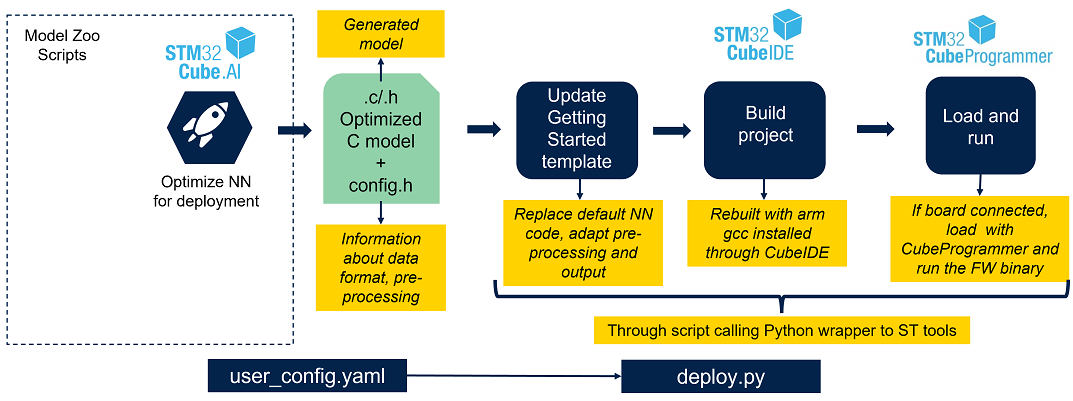

## License

This software component is licensed by ST under BSD-3-Clause license,
the "License"; 

You may not use this file except in compliance with the
License. 

You may obtain a copy of the License at: https://opensource.org/licenses/BSD-3-Clause

Copyright (c) 2023 STMicroelectronics. All rights reserved

## Proxy setting

If you are behind a proxy, you can uncomment and fill the following proxy setting.

**NOTE**: If the password contains some special characters like `@`, `:` etc. they need to be url-encoded.

In [ ]:
# import os
# os.environ['http_proxy'] = "http://user:passwd@ip_address:port"
# os.environ['https_proxy'] = "https://user:passwd@ip_address:port"
# And eventually disable SSL verification
# os.environ['NO_SSL_VERIFY'] = 1

# Install package

In [ ]:
import sys
# If you want to use your venv in the notebook you should launch in your python kernel:
# python -m ipykernel install --user --name=st_zoo
!{sys.executable} -m pip install -r ../../requirements.txt
!{sys.executable} -m pip install ipywidgets
!{sys.executable} -m pip install ruamel.yaml

# Import dependencies

In [ ]:
import ipywidgets as widgets
import json
import os
import glob
import ruamel.yaml
import sys
import hydra
from omegaconf import DictConfig
from omegaconf import OmegaConf
from hydra.core.hydra_config import HydraConfig
import distutils.util
import getpass

In [ ]:
Hardware_list = {
    'Boards':[{"STM32H747I-DISCO":{"Camera":[
                             {"OV5640":
                                 {"Display":["LCD_DISCO_Board"]}
                             }]}},
              {"NUCLEO-H743ZI2":{"Camera":[
                              {"CAMERA_INTERFACE_DCMI":
                               {"Display":["DISPLAY_INTERFACE_USB", "DISPLAY_INTERFACE_SPI"]}
                              },
                              {"CAMERA_INTERFACE_USB":
                               {"Display":["DISPLAY_INTERFACE_SPI"]}
                              },
                              {"CAMERA_INTERFACE_SPI":
                               {"Display":["DISPLAY_INTERFACE_USB", "DISPLAY_INTERFACE_SPI"]}
                              },]
                             }
              }
             ]
}

## 1. Select your Board

In [ ]:
board_list =  [str(*board.keys()) for board in Hardware_list["Boards"]]

In [ ]:
board_name = widgets.Dropdown(
    options=board_list,
    value=board_list[0],
    description='Board Name:',
    disabled=False,
)
display(board_name)

In [ ]:
board_selected = board_name.get_interact_value()

## 2. Select your camera

In [ ]:
for i, board in enumerate(Hardware_list["Boards"]):
    if( board_selected == str(*board.keys())):
        index_board = i
        camera_list = [str(*board.keys()) for board in board[str(*board.keys())]["Camera"]]

In [ ]:
camera_name = widgets.Dropdown(
    options=camera_list,
    value=camera_list[0],
    description='Camera:',
    disabled=False,
)
display(camera_name)

In [ ]:
camera_selected = camera_name.get_interact_value()

## 3. Select your display mode

In [ ]:
for i, camera in enumerate(Hardware_list["Boards"][index_board][str(*Hardware_list["Boards"][index_board].keys())]['Camera']):
    if( camera_selected == str(*camera.keys())):
        display_list = [display for display in camera[camera_selected]["Display"]]    

In [ ]:
display_name = widgets.Dropdown(
    options=display_list,
    value=display_list[0],
    description='Display:',
    disabled=False,
)
display(display_name)

In [ ]:
display_selected = display_name.get_interact_value()

## 4. Select your Model

nb: Note that some models may not fit in your board because of the size of the model

In [ ]:
models_list = [os.path.relpath(model, "../pretrained_models").split(os.sep)[2]+ ": " +  os.path.relpath(model, "..\\pretrained_models").split(os.sep)[-1] for model in glob.glob('../pretrained_models/**/*.tflite', recursive = True)]
modelspath_list = [model for model in glob.glob('../pretrained_models/**/*.tflite', recursive = True)]

In [ ]:
model_name = widgets.Dropdown(
    options=models_list,
    value=models_list[0],
    description='Model:',
    disabled=False,
)
display(model_name)

In [ ]:
model_selected = model_name.get_interact_value()
model_selected_path = modelspath_list[model_name.index]
model_selected_path

## 5. Select the aspect ratio configuration

In [ ]:
aspect_ratio_list = ["fit", "crop", "padding"] if board_selected == "STM32H747I-DISCO" else ["fit", "crop"]

In [ ]:
aspect_ratio_name = widgets.Dropdown(
    options=aspect_ratio_list,
    value=aspect_ratio_list[0],
    description='Aspect ratio mode:',
    disabled=False,
)
display(aspect_ratio_name)

In [ ]:
aspect_ratio_selected = aspect_ratio_name.get_interact_value()
aspect_ratio_selected

## 6. Provide your CubeIDE Path to build and flash

In [ ]:
path_to_cubeIDE = ""

## 7.1 Provide a local Cube.AI path

In [ ]:
path_to_stm32ai = "" # FIll with your path
dev_cloud_used = False
username = ''
password = ''

## 7.2 Or Login to STM32Cube.AI Developer Cloud
Set environment variables with your credentials to access STM32Cube.AI Developer Cloud.

If you don't have an account yet go to: https://stm32ai-cs.st.com/home and click on sign in to create an account. 

Then set the environment variables below with your credentials.


In [ ]:
# Set environment variables with your credentials to access 
# STM32Cube.AI Developer Cloud services
# Fill the username with your login address
username = 'xxx@yyy.com'
os.environ['stmai_username'] = username
print('Enter you password')
password = getpass.getpass()
os.environ['stmai_password'] = password
dev_cloud_used = True

## 7. Fill the deployment config file

In [ ]:
conf_user = {
    "Board": board_selected,
    "Camera": camera_selected,
    "Display": display_selected,
    "Model": model_selected,
    "Model_path": model_selected_path,
    "Aspect Ratio Mode": aspect_ratio_selected,
    "path_to_stm32ai": path_to_stm32ai if 'path_to_stm32ai' in globals() else '',
    "path_to_cubeIDE": path_to_cubeIDE
}

In [ ]:
yaml = ruamel.yaml.YAML()
with open (glob.glob(os.path.dirname(model_selected_path)+"/*.yaml")[0], "r") as f_confmodel:
    conf_model = yaml.load(f_confmodel)
yaml = ruamel.yaml.YAML()
with open('../src/user_config.yaml', 'r+') as fp:
    conf_deploy = yaml.load(fp)
    conf_deploy["general"]["project_name"] = conf_model["general"]["project_name"]
    conf_deploy["general"]["model_path"] = conf_user["Model_path"]
    
    conf_deploy["dataset"]["name"] = conf_model["dataset"]["name"]
    conf_deploy["dataset"]["class_names"] = conf_model["dataset"]["class_names"]
    
    conf_deploy["preprocessing"] = conf_model["preprocessing"]
    conf_deploy["preprocessing"]["resizing"]["aspect_ratio"] = conf_user["Aspect Ratio Mode"]
    
    # Input/output model
    conf_deploy["quantization"]["quantization_input_type"] = conf_model["quantization"]["quantization_input_type"]
    conf_deploy["quantization"]["quantization_output_type"] = conf_model["quantization"]["quantization_output_type"]
    
    # Settings linked to user installation
    conf_deploy["tools"]["path_to_cubeIDE"] = conf_user["path_to_cubeIDE"]
    if dev_cloud_used == False:
        conf_deploy["tools"]["stm32ai"]["path_to_stm32ai"] = conf_user["path_to_stm32ai"]
        conf_deploy["tools"]["stm32ai"]["on_cloud"] = False
    else:
        conf_deploy["tools"]["stm32ai"]["on_cloud"] = True
    
    conf_deploy["deployment"]["hardware_setup"]["board"] = conf_user["Board"]
    conf_deploy["deployment"]["hardware_setup"]["input"] = conf_user["Camera"]
    conf_deploy["deployment"]["hardware_setup"]["output"] = conf_user["Display"]

    conf_deploy["operation_mode"] = "deployment"
    
    fp.seek(0)
    fp.truncate()
    yaml.dump(conf_deploy, fp)

## 8. Flash the model to the given Hardware

The following cell will:
1. Generate C network files corresponding to your model. It will use either the Dev cloud or a local Cube.AI depending if you have logged in with the dev cloud in the previous cells
2. Evaluate the footprint of the model depending on the hardware
3. Build the C project
4. Flash it through ST Link if the selected board is connected to your computer

In [ ]:
os.chdir('../src')

hydra.core.global_hydra.GlobalHydra.instance().clear()
%run -i stm32ai_main.py